# PoC、研究開発にて使われる指標

このnotebookでは、イジング計算機を用いて実証実験 (PoC)、研究開発を行う際に、ソルバーの性能を確認するためにどのような指標、データを見るべきかを解説します。また、本環境を通して利用できるベンチマーク機能に関しても紹介します。

題材として、**巡回セールスマン問題**を用います。

![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/tsp1.png)
![](https://raw.githubusercontent.com/Jij-Inc/JijHandsOnMaterials/handson-environment/ja/images/tsp2.png)


## JijModelingでの数理モデル構築

In [1]:
import jijzept as jz
import jijmodeling as jm

# 問題の生成
problem = jm.Problem("travelling_salesman")
dist = jm.Placeholder("dist", dim=2)
N = jm.Placeholder("N")
x = jm.Binary("x", shape=(N, N))
i = jm.Element("i", N)
j = jm.Element("j", N)
t = jm.Element("t", N)
# Objective Funtion
sum_list = [t, i, j]
obj = jm.Sum(sum_list, dist[i, j] * x[t, i] * x[(t + 1) % N, j])
problem += obj
# const1: onehot for time
const1 = x[t, :]
problem += jm.Constraint(
    "onehot_time",
    const1 == 1,
    forall=[
        t,
    ],
)
# const2: onehot for location
const2 = x[:, i]
problem += jm.Constraint(
    "onehot_location",
    const2 == 1,
    forall=[
        i,
    ],
)

problem

In [2]:
# インスタンスデータの用意
# 今回は説明の都合上、最適解がすでに分かっているインスタンスを使用します。
# このインスタンスでは、最適値となるコストは39です。
instance_data = {"N": 17, "dist": [[9999, 3, 5, 48, 48, 8, 8, 5, 5, 3, 3, 0, 3, 5, 8, 8, 5], [3, 9999, 3, 48, 48, 8, 8, 5, 5, 0, 0, 3, 0, 3, 8, 8, 5], [5, 3, 9999, 72, 72, 48, 48, 24, 24, 3, 3, 5, 3, 0, 48, 48, 24], [48, 48, 74, 9999, 0, 6, 6, 12, 12, 48, 48, 48, 48, 74, 6, 6, 12], [48, 48, 74, 0, 9999, 6, 6, 12, 12, 48, 48, 48, 48, 74, 6, 6, 12], [8, 8, 50, 6, 6, 9999, 0, 8, 8, 8, 8, 8, 8, 50, 0, 0, 8], [8, 8, 50, 6, 6, 0, 9999, 8, 8, 8, 8, 8, 8, 50, 0, 0, 8], [5, 5, 26, 12, 12, 8, 8, 9999, 0, 5, 5, 5, 5, 26, 8, 8, 0], [5, 5, 26, 12, 12, 8, 8, 0, 9999, 5, 5, 5, 5, 26, 8, 8, 0], [3, 0, 3, 48, 48, 8, 8, 5, 5, 9999, 0, 3, 0, 3, 8, 8, 5], [3, 0, 3, 48, 48, 8, 8, 5, 5, 0, 9999, 3, 0, 3, 8, 8, 5], [0, 3, 5, 48, 48, 8, 8, 5, 5, 3, 3, 9999, 3, 5, 8, 8, 5], [3, 0, 3, 48, 48, 8, 8, 5, 5, 0, 0, 3, 9999, 3, 8, 8, 5], [5, 3, 0, 72, 72, 48, 48, 24, 24, 3, 3, 5, 3, 9999, 48, 48, 24], [8, 8, 50, 6, 6, 0, 0, 8, 8, 8, 8, 8, 8, 50, 9999, 0, 8], [8, 8, 50, 6, 6, 0, 0, 8, 8, 8, 8, 8, 8, 50, 0, 9999, 8], [5, 5, 26, 12, 12, 8, 8, 0, 0, 5, 5, 5, 5, 26, 8, 8, 9999]], "opt_value": 39}

## 性能評価に用いる指標について

イジング計算機、量子デバイスの性能を評価するにあたりよく用いられる基本的な指標として、次のような量があります。

### QUBO、イジング模型に関連する量

* **計算時間**

ソルバーが問題を解くのに要する時間です。

* **エネルギー値**

ソルバーによって得られた解の持つエネルギー値です。

* **成功確率 (success_probability)**

全体の試行における、最適解が得られた確率です。1に近づくほど最適解が得られる確率が高いことを表します。
$$
\frac{最適解が出た回数}{全体の試行回数}
$$

* **残留エネルギー (resudial energy)**

最適解となるエネルギー値と、得られたサンプルのエネルギー値の差分を表します。0に近づくほど最適解に近い解を得ていることを表します。

$$
\frac{得られたサンプルのエネルギー - 最適解のエネルギー}{|最適解のエネルギー|}
$$

* **time-to-solution (TTS)**

最適解がある確率$p_r$ (99%とすることが多いです) で得られる典型的な時間を表します。

上で述べた成功確率とは違い、解を得るのに費やした時間も考慮に入るため、ソルバーのフェアな比較手法としてよく用いられる量です。

小さければ小さいほど、短い時間で最適解にたどり着きやすいことを示しています。

導出方法は[こちら](https://tutorial.openjij.org/build/html/ja/002-Evaluation.html#Time-to-solution)をご覧ください。

$$
求解に要した時間 \times \frac{\log{(1-p_r)}}{\log{(1-成功確率)}} 
$$

* **time-to-derived-solution**
**計算中で得られている最も小さい解**がある確率$p_r$ (99%とすることが多いです) で得られる典型的な時間を表します。

多くの場合ではそもそも最適解がわからないケースがほとんどなので、TTSの代わりによく用いられます。


### 制約条件のある数理モデルに関連する量

* **目的関数**

コストを表す量です。(制約条件を満たしている条件のもとで)小さければ小さいほど良い解が得られたことになります。

* **制約条件の破れ具合**

制約条件がどの程度破れているかを表す量です。

* **実行可能解を得る確率 (feasible rate)**

全体の試行における、実行可能解 (制約条件を満たす解)が得られた確率です。1に近づくほど制約条件を満たしやすいことを表します。
$$
\frac{実行可能解が出た回数}{全体の試行回数}
$$

* **time-to-feasible-solution**

実行可能解がある確率$p_r$ (99%とすることが多いです) で得られる典型的な時間を表します。


## JijModeling, JijZeptを用いた計算例

先程作成した巡回セールスマン問題の数理モデルをQUBOモデルに変換する際、制約条件をペナルティ項として扱ったときの

$$
\begin{aligned}
\sum_{i,j}d_{i,j}x_{i,t} x_{j,(t+1)\mod n} + A\sum_{i}\left(\sum_t x_{i,t}-1\right)^2 + B\sum_{t}\left(\sum_i x_{i,t}-1\right)^2
\end{aligned}
$$

の$A$、$B$をどのように調整すればよいか、グリッドサーチで調べる研究を行ってみましょう。

<div class="alert alert-block alert-info">
<b>注意:</b> 以下のコードを実行すると、グリッドサーチを行うため、しばらく時間がかかります。
</div>

まず、同じディレクトリに次のような設定で `config.toml`を作成し、保存します。


```toml
[default]
url = "https://api.jijzept.com"
token = "<Your API key from JijZept portal site>"
```

続いて、作成した `config.toml`をJijZeptで使用します。

In [3]:
import numpy as np

# num_sweepsの値を変えつつ、制約条件の係数の大きさで結果がどう変わるか調査したいという場合
sampler = jz.JijSASampler(config="config.toml")

num_reads_list = [10]
onehot_time_list = [0, 2, 4, 6, 8, 10]
onehot_location_list = [0, 2, 4, 6, 8, 10]

opt_value = instance_data["opt_value"]
pr = 0.99
metrics = {
    "num_reads": [],
    "onehot_time": [],
    "onehot_location": [],
    "execution_time": [],
    "success_probability": [],
    "feasible_rate": [],
    "residual_energy": [],
    "min_energy": [],
    "mean_eneagy": [],
    "tts_optimal": [],
    "tts_feasible": [],
    "tts_derived": []
}
for num_reads in num_reads_list:
    for onehot_time in onehot_time_list:
        for onehot_location in onehot_location_list:
            response = sampler.sample_model(
                problem,
                instance_data,
                {"onehot_time": onehot_time, "onehot_location": onehot_location},
                num_reads=num_reads,
            )
            decoded = problem.decode(response, instance_data, {})
            
            t = response.info["sampling_time"] / num_reads
            energy = decoded.energies
            energy_min = energy.min()
            energy_mean = energy.mean()
            residual_energy = (energy_mean - opt_value) / np.abs(opt_value)
            
            num_feasible = len(decoded.feasibles())
            feasible_rate = num_feasible / num_reads
            
            ps_optimal = (energy == opt_value).sum() / num_reads
            ps_derived = (energy <= energy_min).sum() / num_reads
                
            tts_optimal = np.log(1 - pr) / np.log(1 - ps_optimal) * t
            tts_feasible = np.log(1 - pr) / np.log(1 - feasible_rate) * t
            tts_derived = np.log(1 - pr) / np.log(1 - ps_derived) * t
            
            metrics["num_reads"].append(num_reads)
            metrics["onehot_time"].append(onehot_time)
            metrics["onehot_location"].append(onehot_location)
            metrics["execution_time"].append(t)
            metrics["min_energy"].append(energy_min)
            metrics["mean_eneagy"].append(energy_mean)
            metrics["success_probability"].append(ps_optimal)
            metrics["feasible_rate"].append(feasible_rate)
            metrics["residual_energy"].append(residual_energy)
            metrics["tts_optimal"].append(tts_optimal)
            metrics["tts_feasible"].append(tts_feasible)
            metrics["tts_derived"].append(tts_derived)

uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 5f1d66d346944770b637da16f4eba8bf.
It takes a lot of time to get the solution...
You can also access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("5f1d66d346944770b637da16f4eba8bf")
running...
uploading instance ...


/tmp/ipykernel_4859/255983653.py:49: RuntimeWarning: divide by zero encountered in double_scalars
  tts_optimal = np.log(1 - pr) / np.log(1 - ps_optimal) * t
/tmp/ipykernel_4859/255983653.py:50: RuntimeWarning: divide by zero encountered in double_scalars
  tts_feasible = np.log(1 - pr) / np.log(1 - feasible_rate) * t
/tmp/ipykernel_4859/255983653.py:51: RuntimeWarning: divide by zero encountered in log
  tts_derived = np.log(1 - pr) / np.log(1 - ps_derived) * t


submitting query ...
submitted to the queue.
Your solution_id is ad5d218310ca4c35aa17809cf1bc280a.
running...
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 0ca62b4b22e34301b6c7241c81e24b3b.
running...
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 7020181c0ba24e24a5c887975ecffdb5.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 567d663cdd244fbaa950519b2e62927f.
It takes a lot of time to get the solution...
You can also access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("567d663cdd244fbaa950519b2e62927f")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 9dce2bcc94ea40e189205350c650a9e4.
running...
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 9eadfb120c994aa8857ff92d1d9f615c.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 28c5

/tmp/ipykernel_4859/255983653.py:50: RuntimeWarning: divide by zero encountered in log
  tts_feasible = np.log(1 - pr) / np.log(1 - feasible_rate) * t


submitting query ...
submitted to the queue.
Your solution_id is 3f4c8e0766af40d381af22f64878c163.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 9febcab4701c4720b423701627560090.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 3c82f2acf6994d88928cf53d5947cc9d.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is d14f869d79644a3db8284120e889111b.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 9502a8ed35d84f83aefd9550d9db1927.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is a53eb9171902485ab1c4603e7e9ee371.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is ef307eee68084faca315ed56340c3c85.
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 22c55cdd2aea43e0a9d6d091d40af246.
It takes a lot of time to get the solution...
Y

In [4]:
import pandas as pd

metrics_df = pd.DataFrame(metrics)
metrics_df

,num_reads,onehot_time,onehot_location,execution_time,success_probability,feasible_rate,residual_energy,min_energy,mean_eneagy,tts_optimal,tts_feasible,tts_derived
0,10,0,0,20011.264901,0.0,0.0,-1.000000,-5.684342e-14,-5.684342e-14,-inf,-inf,0.000000
1,10,0,2,8750.065198,0.0,0.0,-1.435364,-1.699160e+01,-1.697921e+01,-inf,-inf,382453.892930
2,10,0,4,8788.051599,0.0,0.0,-1.871316,-3.398890e+01,-3.398132e+01,-inf,-inf,384114.228780
3,10,0,6,8834.820701,0.0,0.0,-2.307060,-5.099010e+01,-5.097534e+01,-inf,-inf,386158.444981
4,10,0,8,8566.644898,0.0,0.0,-2.742996,-6.798640e+01,-6.797684e+01,-inf,-inf,374436.831802
5,10,0,10,8888.466298,0.0,0.0,-3.178709,-8.499120e+01,-8.496966e+01,-inf,-inf,388503.223814
6,10,2,0,8885.589201,0.0,0.0,-1.435285,-1.699010e+01,-1.697612e+01,-inf,-inf,388377.469671
7,10,2,2,8824.614401,0.0,1.0,-1.871200,-3.398680e+01,-3.397682e+01,-inf,0.000000e+00,385712.340969
8,10,2,4,8800.650100,0.0,0.9,-2.301993,-5.098990e+01,-5.077774e+01,-inf,1.760130e+04,384664.892766
9,10,2,6,8635.530100,0.0,0.2,-2.691637,-6.797980e+01,-6.597386e+01,-inf,1.782175e+05,377447.713764


試しにペナルティ項の大きさに対するtime-to-feasible-solution (実行可能解に辿り着くまでの時間)をプロットしてみると、

* 一方のペナルティ項が小さいときはtime-to-feasible-solutionが増大する。
* 双方のペナルティ項が同じ程度の比率であれば、time-to-feasible-solutionは増大しない

という結果がこの計算から読み取ることができるので、パラメータをどのように設定したほうがよいかの指針を得ることができます。

<AxesSubplot:xlabel='onehot_time', ylabel='onehot_location'>

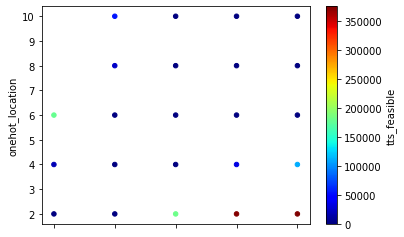

In [5]:
metrics_df.plot.scatter(x='onehot_time', y='onehot_location', c='tts_feasible', cmap='jet')

今回はパラメータのグリッドサーチを例として出しましたが、アニーリング時間や、一回のアニーリングで行う繰り返し回数などのパラメータを様々に変えながら上記の指標を計算することで、各ソルバーにおける性能比較を行うことができます。具体的には以下のような目的でベンチマークを取るケースが多いです。

* パラメータをグリッドサーチしながら、TTS等の指標を見て適切なパラメータの値を探す。
* 異なるソルバー同士の比較のために、アニーリング時間を変えながらTTS等の指標を計算する。

## JijBenchmarkの紹介

ソルバーの性能比較等のためにベンチマークを行う際、上で書いたように**自分で一からデータを集計するためのコードを書かなくてはならない**ので非常に不便です。

JijZeptでは、本環境でローカルでのpython環境の構築が不要になるだけでなく、ベンチマークを行うツールである**JijBenchmark**を利用することができるようになる予定です。

これにより、研究開発、PoCを行う方にとってより便利にご利用いただけます。

### 実行例

例えば、異なるSolver間 (JijSASampler, JijSwapMovingSampler)の性能比較をする際、アニーリング時間 (`num_sweeps`)を変更しながらベンチマークを取りたい場合、以下のように数行で記述するだけで、上で紹介した指標を全て計算し、出力することができます。


In [6]:
import jijbench as jb

num_sweeps_list = [100, 1000, 10000]
tsp, instance_data = jb.get_problem("TSP"), jb.get_instance_data("TSP")

bench = jb.Benchmark(
    params={"num_sweeps": num_sweeps_list, "multipliers": [{"onehot_time": 0.5, "onehot_location": 0.5}]},
    solver="JijSASampler",
    problem=tsp,
    instance_data=instance_data,
    jijzept_config="config.toml",
)
# sync=Falseにするとベンチマークの時間を短縮できます。
bench.run(sync=False)
# TTSなどの、上で紹介した典型的な指標を計算できます。
bench.evaluate(pr=0.99)

uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 1bb18f0fc7494554bffc63827d07e456.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("1bb18f0fc7494554bffc63827d07e456")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 8ad6f69b21b54cb799d81852746a30b2.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("8ad6f69b21b54cb799d81852746a30b2")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is bdb205420ab54fe18de05600743effcd.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("bdb205420ab54fe18de05600743effcd")


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


uploading instance ...


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


submitting query ...
submitted to the queue.
Your solution_id is 664e11c8c20547d099bd8cab5ed4a64c.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("664e11c8c20547d099bd8cab5ed4a64c")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 2c1b0625fb394725a004f3e1c70e9332.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("2c1b0625fb394725a004f3e1c70e9332")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is fea4827826f64c64b34d8a68528b7f0d.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("fea4827826f64c64b34d8a68528b7f0d")


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


uploading instance ...


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


submitting query ...
submitted to the queue.
Your solution_id is 948b5163e3ff4384b279a43337986932.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("948b5163e3ff4384b279a43337986932")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 03ad0626110a4ac7aed09376cadd496f.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("03ad0626110a4ac7aed09376cadd496f")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 9c5ca31b4b594617a8085a604fadfde1.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("9c5ca31b4b594617a8085a604fadfde1")


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


uploading instance ...


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


submitting query ...
submitted to the queue.
Your solution_id is 6a3b456816574bbf9f317109072a1728.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("6a3b456816574bbf9f317109072a1728")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 1e5cb5d62ea143b4b50ae2b795d1fc28.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("1e5cb5d62ea143b4b50ae2b795d1fc28")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is d2df263ef52a4020816e7b83b6121234.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("d2df263ef52a4020816e7b83b6121234")


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


uploading instance ...


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


submitting query ...
submitted to the queue.
Your solution_id is e43ee52186184fb0824511829d0ad719.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("e43ee52186184fb0824511829d0ad719")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is b0313dbf407d4577be1d7ef03b1650d9.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("b0313dbf407d4577be1d7ef03b1650d9")
uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 6f67a9affb50470e986cd0cba539848f.
You can access the solution by
>>> a = XXXSampler(config=...)
>>> a.get_result("6f67a9affb50470e986cd0cba539848f")


/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan
/home/kohei/Project/JijHandsOnMaterials/.venv/lib/python3.9/site-packages/jijbench/experiment/experiment.py:83: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  self._table.data.loc[self._table.current_index] = np.nan


,success_probability,feasible_rate,residual_energy,TTS(optimal),TTS(feasible),TTS(derived)
0,1.0,0.0,-1.003697,5407.190235,1.789216e+21,5407.190235
1,1.0,0.0,-1.003705,29641.245360,9.808160e+21,29641.245360
2,1.0,0.0,-1.003708,273221.165994,9.040770e+22,273221.165994
3,1.0,1.0,-1.012220,1721.127674,1.721128e+03,1721.127674
4,1.0,1.0,-1.012220,9323.400987,9.323401e+03,9323.400987
5,1.0,1.0,-1.012220,86478.461553,8.647846e+04,86478.461553
6,1.0,1.0,-1.013219,1398.931742,1.398932e+03,1398.931742
7,1.0,1.0,-1.013219,7951.587463,7.951587e+03,7951.587463
8,1.0,1.0,-1.013219,70778.010358,7.077801e+04,70778.010358
9,1.0,1.0,-1.217505,237.024581,2.370246e+02,237.024581


In [7]:
# 結果は全てBenchmark.table(pandas.DataFrame)に保存される。
# 上で紹介した指標が全て自動で計算されます。
bench.table

,benchmark_id,experiment_id,run_id,timestamp,energy,energy_min,energy_mean,energy_std,objective,obj_min,...,onehot_location_violations,onehot_location_violation_min,onehot_location_violation_mean,onehot_location_violation_std,success_probability,feasible_rate,residual_energy,TTS(optimal),TTS(feasible),TTS(derived)
0,b700827c-e283-4895-81a2-0d68407c5b41,0671f9d8-eda1-4f5b-bea9-50d1a76b5971,22a2c37a-d2c7-4ed1-b621-b773f7f7ee68,2022-07-25 00:55:07.928640,[-20.77751937988498],-20.777519,-20.777519,0.0,[1148.0],1148.0,...,[1.0],1.0,1.0,0.0,1.0,0.0,-1.003697,5407.190235,1.789216e+21,5407.190235
1,b700827c-e283-4895-81a2-0d68407c5b41,0671f9d8-eda1-4f5b-bea9-50d1a76b5971,96e8ea8a-a45f-4754-8f1a-1d508ffd1306,2022-07-25 00:55:10.314979,[-20.823255813993505],-20.823256,-20.823256,0.0,[912.0],912.0,...,[1.0],1.0,1.0,0.0,1.0,0.0,-1.003705,29641.245360,9.808160e+21,29641.245360
2,b700827c-e283-4895-81a2-0d68407c5b41,0671f9d8-eda1-4f5b-bea9-50d1a76b5971,755c8dba-286d-476b-a2f0-ef7d787409dd,2022-07-25 00:55:16.832430,[-20.840891472908236],-20.840891,-20.840891,0.0,[821.0],821.0,...,[1.0],1.0,1.0,0.0,1.0,0.0,-1.003708,273221.165994,9.040770e+22,273221.165994
3,b700827c-e283-4895-81a2-0d68407c5b41,620cc6e6-93e3-4ff5-8343-1d7dfa1ecfcc,3fc6a9a2-6c89-4956-8c8d-9217d7e0971b,2022-07-25 00:55:22.501767,[-17.999949130010915],-17.999949,-17.999949,0.0,[5087.0],5087.0,...,[0.0],0.0,0.0,0.0,1.0,1.0,-1.012220,1721.127674,1.721128e+03,1721.127674
4,b700827c-e283-4895-81a2-0d68407c5b41,620cc6e6-93e3-4ff5-8343-1d7dfa1ecfcc,b13c86d2-fb5a-4db2-8f96-fadadb240142,2022-07-25 00:55:23.984891,[-17.999948730010914],-17.999949,-17.999949,0.0,[5127.0],5127.0,...,[0.0],0.0,0.0,0.0,1.0,1.0,-1.012220,9323.400987,9.323401e+03,9323.400987
5,b700827c-e283-4895-81a2-0d68407c5b41,620cc6e6-93e3-4ff5-8343-1d7dfa1ecfcc,546cc029-5575-4fa9-a0e4-4891f9d6d55d,2022-07-25 00:55:54.732326,[-17.999948100010915],-17.999948,-17.999948,0.0,[5190.0],5190.0,...,[0.0],0.0,0.0,0.0,1.0,1.0,-1.012220,86478.461553,8.647846e+04,86478.461553
6,b700827c-e283-4895-81a2-0d68407c5b41,0b421b4d-3b96-4172-a437-a8a9b62212c4,85864c86-e9fd-406e-8bea-82038a13bbeb,2022-07-25 00:56:00.403325,[-16.99995530999818],-16.999955,-16.999955,0.0,[4469.0],4469.0,...,[0.0],0.0,0.0,0.0,1.0,1.0,-1.013219,1398.931742,1.398932e+03,1398.931742
7,b700827c-e283-4895-81a2-0d68407c5b41,0b421b4d-3b96-4172-a437-a8a9b62212c4,0922f45f-9bed-422d-a493-69a30b73db82,2022-07-25 00:56:01.700440,[-16.99995660999818],-16.999957,-16.999957,0.0,[4339.0],4339.0,...,[0.0],0.0,0.0,0.0,1.0,1.0,-1.013219,7951.587463,7.951587e+03,7951.587463
8,b700827c-e283-4895-81a2-0d68407c5b41,0b421b4d-3b96-4172-a437-a8a9b62212c4,8151a438-3411-4ae7-be3b-f1d111254c2b,2022-07-25 00:56:03.069659,[-16.999954679998183],-16.999955,-16.999955,0.0,[4532.0],4532.0,...,[0.0],0.0,0.0,0.0,1.0,1.0,-1.013219,70778.010358,7.077801e+04,70778.010358
9,b700827c-e283-4895-81a2-0d68407c5b41,ed8314cf-1256-4d09-bc43-e7070e20d6b0,69a58a6d-576a-4a90-bf18-64ee1b5d7969,2022-07-25 00:56:07.048273,[-8.482698269826983],-8.482698,-8.482698,0.0,[173.0],173.0,...,[0.0],0.0,0.0,0.0,1.0,1.0,-1.217505,237.024581,2.370246e+02,237.024581


In [8]:
# bench.tableの一部だけ表示
columns = [
        "num_reads",
        "multipliers",
        "execution_time",
        "success_probability",
        "feasible_rate",
        "residual_energy",
        "energy_min",
        "energy_mean",
        "TTS(optimal)",
        "TTS(feasible)",
        "TTS(derived)",
]
bench.table[columns]

,num_reads,multipliers,execution_time,success_probability,feasible_rate,residual_energy,energy_min,energy_mean,TTS(optimal),TTS(feasible),TTS(derived)
0,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",4.313475e+04,1.0,0.0,-1.003697,-20.777519,-20.777519,5407.190235,1.789216e+21,5407.190235
1,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",2.364570e+05,1.0,0.0,-1.003705,-20.823256,-20.823256,29641.245360,9.808160e+21,29641.245360
2,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",2.179566e+06,1.0,0.0,-1.003708,-20.840891,-20.840891,273221.165994,9.040770e+22,273221.165994
3,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",1.372994e+04,1.0,1.0,-1.012220,-17.999949,-17.999949,1721.127674,1.721128e+03,1721.127674
4,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",7.437552e+04,1.0,1.0,-1.012220,-17.999949,-17.999949,9323.400987,9.323401e+03,9323.400987
5,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",6.898642e+05,1.0,1.0,-1.012220,-17.999948,-17.999948,86478.461553,8.647846e+04,86478.461553
6,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",1.115969e+04,1.0,1.0,-1.013219,-16.999955,-16.999955,1398.931742,1.398932e+03,1398.931742
7,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",6.343216e+04,1.0,1.0,-1.013219,-16.999957,-16.999957,7951.587463,7.951587e+03,7951.587463
8,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",5.646171e+05,1.0,1.0,-1.013219,-16.999955,-16.999955,70778.010358,7.077801e+04,70778.010358
9,1,"{'onehot_time': 0.5, 'onehot_location': 0.5}",1.890815e+03,1.0,1.0,-1.217505,-8.482698,-8.482698,237.024581,2.370246e+02,237.024581
